## ✨Анализ A/B–тестирования механики продаж

#### 1.1. Исходное положение

> Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2. Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [3]:
import pandas as pd

import scipy
from scipy import stats
from scipy.stats import ttest_ind
import pingouin as pg
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pingouin as pg
from scipy.stats import shapiro, normaltest
from scipy.stats import chi2_contingency
import scipy.stats as stats
import pandahouse as ph
from datetime import datetime

In [2]:
OUTDATED_IGNORE=1

###### Загружаю данные

In [26]:
df_1 = pd.read_csv('Проект_2_groups.csv', sep=';')
df_1.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [205]:
df_1.shape

(74484, 2)

In [219]:
df_1.dtypes

id      int64
grp    object
dtype: object

In [29]:
df_2 = pd.read_csv('Проект_2_group_add.csv', sep=',')
df_2.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [146]:
df_2.shape

(92, 2)

In [151]:
df_2.dtypes

id      int64
grp    object
dtype: object

In [30]:
df_3 = pd.read_csv('Проект_2_active_studs.csv', sep=';')
df_3.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [208]:
df_3.shape

(8341, 1)

In [104]:
df_3.dtypes

student_id    int64
dtype: object

In [31]:
df_4 = pd.read_csv('Проект_2_checks.csv', sep=';')
df_4.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [274]:
df_4.shape

(541, 2)

###### Предварительная обработка данных

In [131]:
df_1_1 = df_1.merge(df_2, how = 'outer')

In [133]:
df_1_1.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [134]:
df_1.shape

(74484, 2)

1.3.Вопросы

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?

1. Объединю в 1 таблицу всех пользователей и активных пользователей, зашедших на платформу в дни проведения эксперитмента, так как только эти пользователи необходимы для анализа. Только они имели возможность оценть новую механику оплаты

In [35]:
df_1 = df_1.rename(columns={'id': 'student_id'})
df_1.head()

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [198]:
df_1.shape

(74484, 1)

In [210]:
df_1.dtypes

student_id     int64
grp           object
dtype: object

In [36]:
df_1 = df_1.merge(df_3, how = 'right', on = 'student_id')
df_1.head()

,student_id,grp
0,581585,A
1,5723133,NaN
2,3276743,B
3,4238589,A
4,4475369,B


In [279]:
df_1.shape

(8341, 2)

2. Объединяю таблицу с пользователями и таблицу с оплатившими пользователями.

In [37]:
df = df_1.merge(df_4, how = 'left', on = 'student_id')
df.shape

(8341, 3)

In [23]:
df.head()

,student_id,grp,rev
0,581585,A,NaN
1,5723133,NaN,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


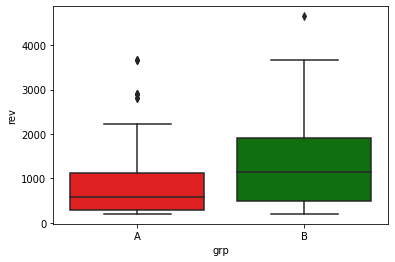

In [241]:
sns.boxplot(x="grp", y="rev", data=df, palette=["r", "g"])

Судя по графику медиана платежей группы b - больше, чем в группе a. Но необходим дальней ший анализ

ниже - Это проверка для задания 3.


In [38]:
df_ARPPU = df.groupby('grp', as_index=False).agg({'rev' : 'mean'}).rename(columns={'rev': 'ARPPU'})
df_ARPPU 

,grp,ARPPU
0,A,933.589744
1,B,1255.827487


In [39]:
df_ARPU = df.groupby('grp', as_index=False).agg({'student_id' : 'nunique'}).rename(columns={'student_id': 'users_count'})
df_ARPU

,grp,users_count
0,A,1535
1,B,6793


In [40]:
df_cr = df.groupby('grp', as_index=False).agg({'rev' : 'count'}).rename(columns={'rev': 'purchase_count'}).merge(df_ARPU, how = 'inner', on = 'grp').merge(df_ARPPU, how = 'inner', on = 'grp')
df_cr

,grp,purchase_count,users_count,ARPPU
0,A,78,1535,933.589744
1,B,313,6793,1255.827487


In [41]:
df_cr['cr'] = df_cr.purchase_count/df_cr.users_count
df_cr ['ARPU'] = df_cr.cr*df_cr.ARPPU
df_cr= round(df_cr,3).drop(['purchase_count', 'users_count'], axis = 1)
df_cr

,grp,ARPPU,cr,ARPU
0,A,933.590,0.051,47.440
1,B,1255.827,0.046,57.865


<Figure size 432x288 with 0 Axes>

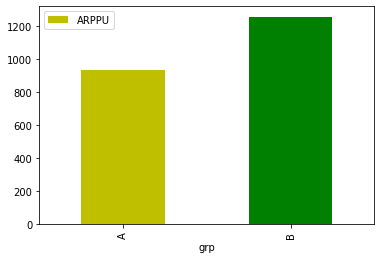

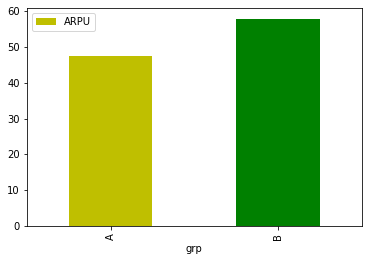

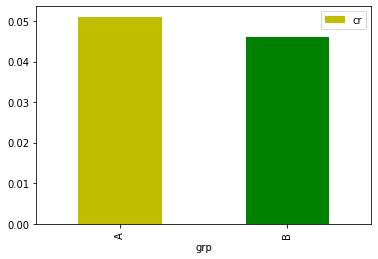

In [93]:
fig, figsize=(20, 5)
df_cr.plot (kind='bar', x='grp', y='ARPPU', color=['y', 'g'])
df_cr.plot (kind='bar', x='grp', y='ARPU', color=['y', 'g'])
df_cr.plot (kind='bar', x='grp', y='cr', color=['y', 'g'])
plt.show()

3. Далее 1 задание. Разделяю данные по группам

In [56]:
df_a = df[df['grp'] == 'A'].rename(columns={'grp': 'control_group'})
df_a.shape

(1538, 3)

In [57]:
df_b = df[df['grp'] == 'B'].rename(columns={'grp': 'target_group'})
df_b.shape

(6803, 3)

In [456]:
df_a.head()

,student_id,control_group,rev
0,581585,A,NaN
1,5723133,A,NaN
3,4238589,A,NaN
7,1394612,A,NaN
21,5194768,A,NaN


In [457]:
df_b.head()

,student_id,target_group,rev
2,3276743,B,NaN
4,4475369,B,NaN
5,5481015,B,NaN
6,1353433,B,NaN
8,1170611,B,NaN


Посмотрим на размеры платежей в контрольной и целевой группах

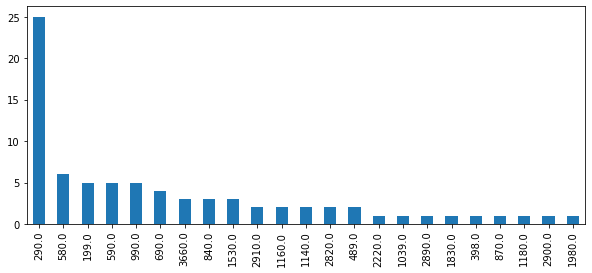

In [428]:
df_a_rev_11 = df_a ['rev'].value_counts()
df_a_rev_11.plot.bar(figsize=( 10, 4 ))

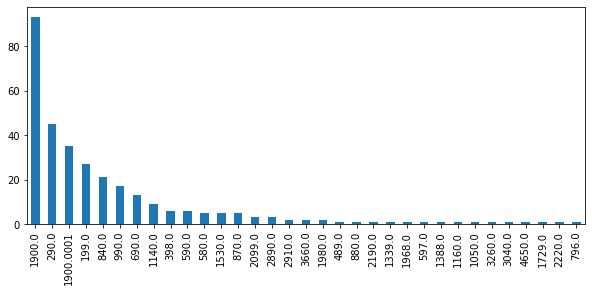

In [429]:
df_b_rev_11 = df_b ['rev'].value_counts()
df_b_rev_11.plot.bar(figsize=( 10, 4 ))

В тестовой группе разброс данных больше, максимальные и минимальные значения больше удалены друг от друга

Найдем количество покупок в контрольной и целевой группах. Для этого найдем количество непустых значнний в столбце student_id

In [58]:
a =len(df_a[df_a['student_id']!= 'NaN'])

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [59]:
a

1538

Это все значения, пустых значений нет

Перепроверим и найдем пустые значения во всем дата фрейме

In [431]:
df_a.isna().sum()

student_id          0
control_group       0
rev              1460
dtype: int64

Следовательно, количество покупок в контрльной группе = 78

In [432]:
Count_rev_a = 1538 - 1460
Count_rev_a

78

Проверим еще раз. Используем метод isnull() для поиска пустых значений в столбце rev

In [290]:

df_a_1 = df_a.isnull()
df_a_1


,student_id,control_group,rev
0,False,False,True
1,False,False,True
3,False,False,True
7,False,False,True
21,False,False,True
...,...,...,...
8317,False,False,True
8320,False,False,True
8326,False,False,True
8330,False,False,True


In [68]:
df_a_count = df_a.groupby('student_id', as_index=False).agg({'rev' : 'count'})
df_a_count

,student_id,rev
0,1627,1
1,3391,0
2,109623,0
3,133678,0
4,175944,0
...,...,...
1533,5668989,0
1534,5690284,0
1535,5723133,0
1536,5729371,0


Количество строк дата фрейма не изменилось. Это говорит нам, что пользователей совершивших повторные покупки в контрольной группе за рассматриваемый период нет

In [292]:
df_a_count.rev.unique ()

array([1, 0])

In [72]:
df_a_count_rev = sum(df_a_count.rev)
df_a_count_rev
# сошлось с предыдущим способом. Количество покупок в контрольной группе = 78

78

Сделаем также для целевой группы

In [60]:
b = len(df_b[df_b['student_id']!= 'NaN'])

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [61]:
b

6803

В столбце student_id нет пустых значений. Перепроверка

In [435]:
df_b.isna().sum()

student_id         0
target_group       0
rev             6489
dtype: int64

Следовательно, количество покупок в контрльной группе = 314

In [436]:
Count_rev_b = 6803 - 6489
Count_rev_b

314

Проверим еще раз. Используем метод isnull() для поиска пустых значений в столбце rev

In [437]:
df_b_1 = df_b.isnull()
df_b_1

,student_id,target_group,rev
2,False,False,True
4,False,False,True
5,False,False,True
6,False,False,True
8,False,False,True
...,...,...,...
8336,False,False,True
8337,False,False,True
8338,False,False,True
8339,False,False,False


In [69]:
df_b_count = df_b.groupby('student_id', as_index=False).agg({'rev' : 'count'})
df_b_count

,student_id,rev
0,2085,0
1,2215,0
2,3401,0
3,22994,0
4,26899,0
...,...,...
6798,5740903,1
6799,5760471,0
6800,5777081,0
6801,5945085,0


Количество строк дата фрейма не изменилось. Это говорит нам, что пользователей совершивших повторные покупки в тестовой группе за рассматриваемый период нет

In [299]:
df_b_count.rev.unique ()

array([0, 1])

In [70]:
df_b_count_rev = sum(df_b_count.rev)
df_b_count_rev                 
# сошлось с предыдущим способом.Количество покупок в целевой группе = 314

314

###### В качестве метрик можем использовать конверсию и показатели доходов. Мы не можем использовать точный показатель ARPPU, у нас нет повтореных покупок. Но можем прировнять его к среднему чеку (AOV), то есть рассчитать только итоговый средний чек покупателей по группам (рассмотреть его как ARPPU -  нашем случае он и будет средним доходом с платящего пользователя),  Мы можем рассчитать ARPU  - средний платеж на всех  пользователей (унас они только активные).  Мы не можем рассчитать retention (нет данных о повторных покупках); метрики , связанны с прибылью (нет данных по расходам), метрики, связанные с временем (нет данных о датах и времени).

In [73]:
CR_a = round(df_a_count_rev/a*100, 3)
CR_a # Конверсия в покупку в контрольной группе

5.072

In [74]:
CR_b =round(df_b_count_rev/b*100,3)
CR_b # Конверсия в покупку в тестовой группе

4.616

In [75]:
round(CR_b - CR_a, 3)

-0.456

Конверсия в целевой группе ниже, чем в контрольной на 0,005. Это очень маленькая разница. Но далее надо рассмотреть на сколько она статистически значима

Найдем средний чек всех покупок в контрольной группе

In [304]:
average_rev_a = round(df_a['rev'].mean(), 2)
average_rev_a

933.59

Найдем средний чек всех покупок в целевой группе 

In [305]:
average_rev_b = round(df_b['rev'].mean(), 2)
average_rev_b

1257.88

Проверим

In [307]:
df_avg= df.groupby('grp', as_index=False).agg({'rev' : 'mean'}).round(2)
df_avg

,grp,rev
0,A,933.59
1,B,1257.88


In [308]:
round (average_rev_b - average_rev_a, 2)

324.29

Средний чек покупок в целевой группе больше, чем в контрольной на 324, 29 рубля. На мой взгляд, это основной показатель в даных, именно на него влияет механика оплаты. Далее необходимо определить является ли эта разница стат значимой.

Рассчитаем ARPU = конверсия * средний чек (показатель получится по всем пользователям в группах)

In [309]:
arpu_a = round(CR_a * average_rev_a, 2)
arpu_a




47.61

In [310]:
arpu_b = round (CR_b * average_rev_b, 2)
arpu_b

57.86

In [311]:
arpu_b - arpu_a

10.25

Cредний доход с привлечённого пользователя  в целевой группе также больше, чем в контрольной на 10,25 рубля. Далее необходимо определить является ли эта разница стат значимой. 

#### Гипотеза 1
Нами расчитан ARPAU (в нашем случае средний чек на всех привлеченных пользователей, не только платящих). Он увеличился 10,25 рубля. H0 - новый алгоритм не повлиял стат значимо на данный показатель (ARPU) в тестовой группе. H1 -новая механика оплаты статистически значимо улучшила качество сервиса, (ARPU) в целевой группе.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


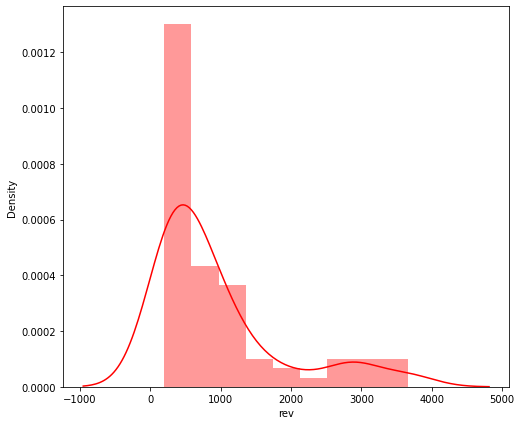

In [458]:
fig = plt.figure
fig,ax= plt.subplots(figsize=(8,7))
sns.distplot(df_a.rev,color='red',label='доход',ax=ax)
plt.show()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


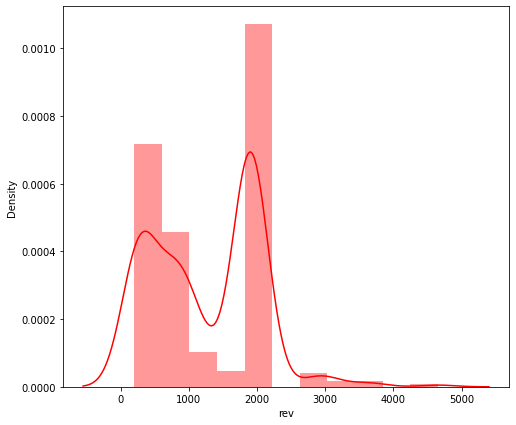

In [400]:
fig = plt.figure
fig,ax= plt.subplots(figsize=(8,7))
sns.distplot(df_b.rev,color='red',label='доход',ax=ax)
plt.show()

Графики показывают, что распределение данных о доходах от всех посетивших приложение в обеих группах не является нормальным.

In [450]:
df_a_15 = df_a
df_a_15['rev'] = df_a_15['rev'].fillna(0)
df_a_15

,student_id,control_group,rev
0,581585,A,0.0
1,5723133,A,0.0
3,4238589,A,0.0
7,1394612,A,0.0
21,5194768,A,0.0
...,...,...,...
8317,3208984,A,0.0
8320,2900558,A,0.0
8326,1161774,A,0.0
8330,5006972,A,0.0


In [451]:
df_b_15 = df_b
df_b_15['rev'] = df_b['rev'].fillna(0)
df_b_15

,student_id,target_group,rev
2,3276743,B,0.0
4,4475369,B,0.0
5,5481015,B,0.0
6,1353433,B,0.0
8,1170611,B,0.0
...,...,...,...
8336,1794344,B,0.0
8337,296883,B,0.0
8338,3598448,B,0.0
8339,3610547,B,290.0


In [462]:
df_15 = df_a_15.merge(df_b_15, 'outer')
df_15

,student_id,control_group,rev,target_group
0,581585,A,0.0,NaN
1,5723133,A,0.0,NaN
2,4238589,A,0.0,NaN
3,1394612,A,0.0,NaN
4,5194768,A,0.0,NaN
...,...,...,...,...
8336,1794344,NaN,0.0,B
8337,296883,NaN,0.0,B
8338,3598448,NaN,0.0,B
8339,3610547,NaN,290.0,B


In [459]:
stats.normaltest(df_a_15.rev)

NormaltestResult(statistic=2240.5957974074026, pvalue=0.0)

In [460]:
stats.normaltest(df_b_15.rev)

NormaltestResult(statistic=7797.399211581946, pvalue=0.0)

Подвержается, что данные распределены ненормально. Можно использовать либо непараметрический тест - Хи квадрат, например, либо бутстрап. Выборка достаточно большая, можно принебресь ее ненормальностью и использовать t-test, но он иногда дает противорочивый результат. Выбираю бутстрап.  

In [476]:
Bootst_df_a_15 = stats.bootstrap((df_a_15.rev, ), np.mean, n_resamples=15000)
Bootst_df_a_15

BootstrapResult(confidence_interval=ConfidenceInterval(low=34.83127737130079, high=64.48400337558331), standard_error=7.421440557402019)

In [478]:
Bootst_df_b_15 = stats.bootstrap((df_b_15.rev, ), np.mean, n_resamples=15000)
Bootst_df_b_15

BootstrapResult(confidence_interval=ConfidenceInterval(low=50.96251698554571, high=65.88747411870283), standard_error=3.8210256626621226)

Bootstrap показал: интервалы в контрольной и тестовой группах совпадают, соотвественно стат занчимых отклонений межуд ними нет. (Почему-то не получилось рассчитать bootstrap для медиан. Не поняла, почему.)

#### Вывод 1. Метод bootstrap показал, что статистически значимых отклонениний между  доходами от всех атктивных пользователей в целевой группе от доходов от пользователей в контрольной группе нет. Мы не отклоняем нулевую гипотезу.

### Гипотеза 2
##### H0 - новый алгоритм не изменил качество механики оплаты, не увеличился средний чек (ARPPU) в тестовой группе .
###### H1 -новая механика оплаты статистически значимо улучшила качество сервиса, вырос  увеличился общий средний чек (ARPPU) в тестовой группе. 

Так как речь идет именно об улучшении механики оплаты, то основным считаю показатель среднего чека. На коверсию в покупку кроме оплаты влияют другие элеиенты приложения - это переход к оформлению покупки и т.д. На средний чек всех активных ползователей (гипотеза 1) также влияют другие факторы приложения. Пользователь заходит в приложение в нашем случае не потому что там привелекательный механизм оплаты, так как в этих данных каждый совершил по 1 покупке, то есть не мог заранее знать о новом механизме, и механизм для всех пользователей был новый.  Поэтому гипотеза 2 - наиболее важна.

Для того, чтобы проверить нулевую гипотезу проверим статистическую значимость полученных показателей. Проверим распределение данных на нормальность. Визуализируем данные. Будем сравнивать различия average_rev_a и average_rev_b

Подготовим данные для определения нормальности распределения

In [446]:
df_a_stat = df_a_15.query("rev != 0")
df_a_stat

,student_id,control_group,rev
62,1184303,A,1530.0
99,720651,A,1980.0
306,4337103,A,580.0
392,332387,A,2910.0
439,1659434,A,690.0
...,...,...,...
7950,445767,A,3660.0
8025,1202202,A,2910.0
8027,2306271,A,290.0
8204,1390994,A,398.0


In [402]:
df_b_stat = df_b_15.query("rev > 0")
df_b_stat

,student_id,target_group,rev
67,3354191,B,1900.0001
77,3278734,B,1900.0000
193,1232221,B,1900.0000
195,3821501,B,1900.0000
211,1036096,B,1900.0000
...,...,...,...
8109,2692209,B,1900.0001
8191,2081846,B,1900.0000
8201,3890326,B,199.0000
8277,3910596,B,597.0000


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


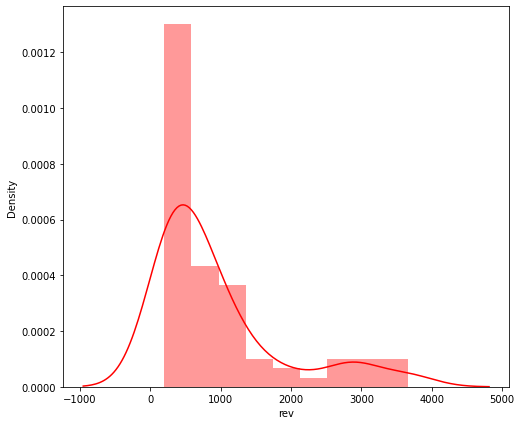

In [403]:
fig = plt.figure
fig,ax= plt.subplots(figsize=(8,7))
sns.distplot(df_a_stat.rev,color='red',label='доход',ax=ax)
plt.show()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


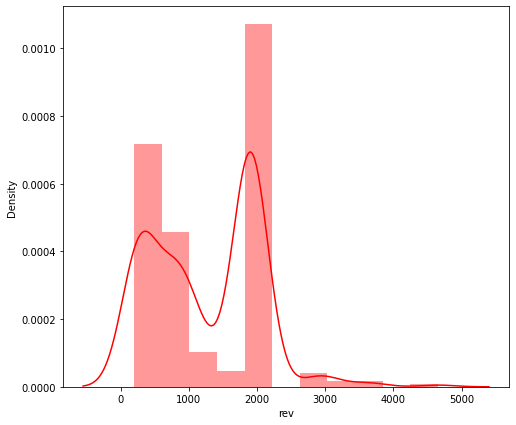

In [404]:
fig = plt.figure
fig,ax= plt.subplots(figsize=(8,7))
sns.distplot(df_b_stat.rev,color='red',label='доход',ax=ax)
plt.show()

Графики показывают, что распределение данных о доходах c плативших пользователей в обеих группах не является нормальным

In [379]:
stats.normaltest(df_a_stat.rev)

NormaltestResult(statistic=30.378419638487458, pvalue=2.531686880422046e-07)

In [380]:
stats.shapiro(df_a_stat.rev)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [381]:
stats.normaltest(df_b_stat.rev)

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

In [382]:
stats.shapiro(df_b_stat.rev)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

Тесты на нормальность показали, что в обеих группах распределение не соответствует нормальному. Данных немого, можно использовть бутстрап 

In [383]:
df_a_boot = df_a_stat.rev
df_a_boot

62      1530.0
99      1980.0
306      580.0
392     2910.0
439      690.0
         ...  
7950    3660.0
8025    2910.0
8027     290.0
8204     398.0
8263     290.0
Name: rev, Length: 78, dtype: float64

In [384]:
df_b_boot = df_b_stat.rev
df_b_boot

67      1900.0001
77      1900.0000
193     1900.0000
195     1900.0000
211     1900.0000
          ...    
8109    1900.0001
8191    1900.0000
8201     199.0000
8277     597.0000
8339     290.0000
Name: rev, Length: 314, dtype: float64

In [385]:
boot_strap_a = stats.bootstrap((df_a_boot, ), np.median, n_resamples=15000)
boot_strap_a

BootstrapResult(confidence_interval=ConfidenceInterval(low=290.0, high=690.0), standard_error=70.36962168450532)

In [391]:
boot_strap_a_mean = stats.bootstrap((df_a_boot, ), np.mean, n_resamples=18000)
boot_strap_a_mean

BootstrapResult(confidence_interval=ConfidenceInterval(low=754.4759714811775, high=1169.1865601867844), standard_error=103.68317717773003)

In [392]:
boot_strap_b_mean = stats.bootstrap((df_b_boot, ), np.mean, n_resamples=18000)
boot_strap_b_mean

BootstrapResult(confidence_interval=ConfidenceInterval(low=1172.0352990702852, high=1347.211638994448), standard_error=44.52656356360694)

#### Вывод 2. Интервалы средних значений в группах не пересекаются, между стандартными ошибками большая разница, следовательно, прирост среднего чека в тестовой группе (ARPPU) статистически значим.  Мы отклоняем нулевую гипотезу и принимаем первую. (Почему-то не получился расчет бутстрапа медианы для целевой группы, соотсетсвенно не получилось сравнить медианы). Вывод 2 противоречит выводу 1.

### Гипотеза 3
##### H0 - новый алгоритм привел к сокращению конверсии (CR  в гурппе B немного меньше, чем CR в группе A) .
###### H1 -новая механика оплаты статистически значимо снизила конверсию. Этот показатель наиболее важен из всех. Но в нашем случае не хватает данных для оценки его важности. Мы не знаем на каких шагах пользователи не стали ничего покупать. Для точных выводо необходимо сравнивать конверсию на последнем шаге именно оплаты у контрольной и целевой группах. Но таких данных нет.

Сравниваем категориальные переменные CR_a и CR_b, можно использовать хи-квадрат

In [514]:
df['rev_done'] = df['rev'].notna().astype(int)
df_done = df.fillna(0)
df_done

,student_id,grp,rev,rev_done
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0
...,...,...,...,...
8336,1794344,B,0.0,0
8337,296883,B,0.0,0
8338,3598448,B,0.0,0
8339,3610547,B,290.0,1


In [529]:
df_done_cr = df_done.groupby('grp', as_index=False).size().rename(columns={'size' : 'count_'})
df_done_cr ['purchase'] = df_done.query('rev_done == 1').groupby('grp', as_index=False).size()['size']
df_done_cr ['CR'] = np.round(df_done_cr.purchase / df_done_cr.count_ * 100, 2)
df_done_cr

,grp,count_,purchase,CR
0,A,1538,78,5.07
1,B,6803,314,4.62


Построим таблицу сопряженности

In [531]:
contingency = df_done_cr[['count_', 'purchase']].values
contingency

array([[1538,   78],
       [6803,  314]])

In [535]:
chi2, p, _, _ = chi2_contingency(contingency)

In [536]:
chi2, p

(0.43612258061018483, 0.5089998823014525)

In [ ]:
chi2, p, _, _ = chi2_contingency(contingency_table)

Вывод 3. Хи квадрат показал, что сокращение конверсии в контрольной и целевой группах статистически не значимо. Мы не отвергаем нулевую гипотезу. Конверсия сокртилась либо случайно, либо за счет других факторов, не изучаемых нами. Следовательно, этот вывод является не значимым для нашего A/B теста. 

###### Вывод
###### Рассматриваем первые две гипотезы, так как третья показывает противоположный статистически не значимый результат. Вторая гипотеза на мой взгляд важнее, соотвественно, я считаю, что мы можем принять изменения по механике оплаты. Но желательно провести еще тестирование через промежуток времени, когда появятся повторные покупки.

## ✨Аналитика успеваемости

2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

In [102]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [103]:
query = """
SELECT 
    st_id,
    timest::DATETIME AS timest,
    correct,
    subject 
    from default.peas
    limit 10
"""
df_peas = ph.read_clickhouse(query, connection=connection_default)
df_peas

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability
5,100379,2021-10-30 18:02:37,1,Theory of probability
6,100379,2021-10-30 18:17:25,1,Vizualization
7,100379,2021-10-30 18:32:26,0,Theory of probability
8,100379,2021-10-30 19:19:33,1,Vizualization
9,100379,2021-10-30 19:28:03,1,Theory of probability


In [43]:
df_peas.dtypes

st_id              object
timest     datetime64[ns]
correct              int8
subject            object
dtype: object

In [104]:
query_1 = """
SELECT* 
    from default.studs
    limit 10
"""
df_studs = ph.read_clickhouse(query_1, connection=connection_default)
df_studs

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot
5,106010,pilot
6,106028,pilot
7,106464,pilot
8,106816,control
9,107250,control


In [105]:
query_2 = """
SELECT
    st_id,
    sale_time::DATETIME AS sale_time,
    money,
    subject 
    from default.final_project_check
    limit 10
"""
df_check = ph.read_clickhouse(query_2, connection=connection_default)
df_check

,st_id,sale_time,money,subject
0,101432,2021-10-31 04:44:32,85000,Math
1,101432,2021-10-31 12:43:50,65000,Vizualization
2,104885,2021-10-30 17:05:55,65000,Vizualization
3,104885,2021-10-30 22:49:33,75000,Statistics
4,106464,2021-10-31 13:17:13,85000,Math
5,114606,2021-10-31 02:26:19,75000,Statistics
6,147316,2021-10-31 11:12:27,65000,Vizualization
7,149640,2021-10-30 19:53:19,65000,Vizualization
8,230858,2021-10-31 08:14:34,85000,Math
9,269738,2021-10-30 21:33:24,70000,Theory of probability


Время, за которое есть данные

In [106]:
query_3 = """
SELECT 
    MIN(timest :: DATE) as min_date,
    MAX(timest :: DATE) as max_date
    from default.peas
    limit 10
"""
df_period = ph.read_clickhouse(query_3, connection=connection_default)
df_period

,min_date,max_date
0,2021-10-30,2021-10-31


2.1.2 Задача

Дана таблица default.peas:
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

Данные представлена за 2 дня 30 и 31 октября 2021 года. Запрос на выявление усердных учеников

In [107]:
query_4 = """
SELECT 
    COUNT (*) as dil_stud
    from 
        (
        SELECT
            SUM(correct) as Correct_task
        from default.peas
        Group by st_id)
    where Correct_task >=20 
    
"""
df_st_dil = ph.read_clickhouse(query_4, connection=connection_default)
df_st_dil

,dil_stud
0,136


Вывод - 136 усердных студента

2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

In [7]:
query_5 = """ --- проверим есть ли в таблице с платежами студенты, которые не платили. Их нет
SELECT 
    COUNT (st_id) 
    FROM default.final_project_check
        Where money is NULL or money = 0
        
"""
df_Sale = ph.read_clickhouse(query_5, connection=connection_default)
df_Sale

,count(st_id)
0,0


В таблице peas - 13245 студентов. В таблице studs - 600 студентов. Далее. Нахожу средний доход от платящего пользователя по группам. Подойдет right, так как нам нужны только платящие пользователи  и только попавшие в группы ) 
FULL дает доход от всех пользосателей, не только платящих, использую его во 2 подзапросе, можно использовать left или rihgt, учитываю всех студентов, попавших в гурппы (600 чел. в таблице studs)  Во 2 подзапросе нахожу ARPU по группам.
Третий  подзапрос  - нахожу ARPAU доход по группам от активных пользователей). Учитываю только активных
в 4 нахожу доходы от активных  математиков и количество купивших из тех, кто активен по математике.
В 5 - разные конверсии через формулы ARPU=Конверсия⋅ARPPU, затем объединяю в 1. Везде учитваю не общих пользоватлей или покупателей, а конверсия активных толь из активных, конверситяматематиков токльо из математиков.
###### Неправильно названа таблица Purchase_active. Там сведения толкьо  о количестве актвиных пользоватетей, всего, не только купивших.

In [124]:
query_6 = """
WITH ARPPU AS 
    (
     SELECT 
    test_grp, round(AVG_, 2) as ARPPU_
  FROM
   (
   SELECT
   test_grp,  AVG (money) as AVG_
from
    default.final_project_check as a
inner JOIN
    default.studs as b
        ON a.st_id = b.st_id
   Group by test_grp
   )
 GROUP BY test_grp, AVG_
    ),
    
ARPU as
    (
      SELECT 
    test_grp, ROUND (AVG_, 2) as ARPU_
  FROM
   (
   SELECT
   test_grp, AVG (money) as AVG_
from
    default.final_project_check as a
FULL JOIN
    default.studs as b
        ON a.st_id = b.st_id
   Group by test_grp
   )
 GROUP BY test_grp, ARPU_
    ),

ARPAU as
    (
      Select
COUNT (active_st ) as COUNT_active_purc,
        ROUND (AVG (money),2) as ARPAU_,
        r.test_grp as test_grp
        FROM 
      (
      Select st_id, 
            COUNT (correct) > 10 as active_st
        FROM default.peas 
        GROUP BY st_id
        )  as l
    
    LEFT JOIN default.studs as r
        ON l.st_id = r.st_id
  INNER JOIN default.final_project_check as d
    ON l.st_id = d.st_id
    GROUP BY test_grp
    ),
    
  Purchase_active as
  (Select
COUNT (active_st ) as COUNT_active,
        r.test_grp as test_grp
        FROM 
      (
      Select st_id, 
            COUNT (correct) > 10 as active_st
        FROM default.peas 
        GROUP BY st_id
        )  as l
      LEFT JOIN default.studs as r
        ON l.st_id = r.st_id
     GROUP BY test_grp
    ),
    
    
MATH as
        (
             SELECT 
          COUNT (math_active_st) as MATH_purch,
          ROUND (AVG (money),2) as Income_MATH,
          r.test_grp as test_grp
        FROM 
        (
      Select 
            st_id, 
            subject as math_active_st
        FROM default.peas
            Where subject = 'Math' 
        GROUP BY st_id, subject
        HAVING COUNT(correct) >= 2
        )  as l
    LEFT JOIN default.studs as r
    ON l.st_id = r.st_id
    INNER JOIN default.final_project_check as d
    ON l.st_id = d.st_id
    GROUP BY r.test_grp
        ),  
  MATH_count as
        (
       SELECT 
  COUNT (math_active_st) as MATH_tot,
        r.test_grp as test_grp
        FROM 
        (
      Select 
            st_id, 
            subject as math_active_st
        FROM default.peas
            Where subject = 'Math' 
        GROUP BY st_id, subject
        HAVING COUNT(correct) >= 2
        )  as l
    LEFT JOIN default.studs as r
    ON l.st_id = r.st_id
    
    GROUP BY r.test_grp
        ),      
CR as
    (
    SELECT 
       a.test_grp as test_grp,
        ROUND (a.ARPU_/b.ARPPU_ *100, 2) as CR,
        ROUND (c.COUNT_active_purc/g.COUNT_active *100, 2) as CR_active_st,
        ROUND (d.MATH_purch/f.MATH_tot *100, 2) as MATH_CR
    FROM ARPU as a
     JOIN ARPPU as b
        ON a.test_grp = b.test_grp
     JOIN ARPAU as c
        ON a.test_grp = c.test_grp
      Inner JOIN Purchase_active as g
       ON a.test_grp = g.test_grp
      Inner JOIN MATH as d  
      ON a.test_grp = d.test_grp
      Inner JOIN MATH_count as f  
      ON a.test_grp = f.test_grp
        GROUP BY test_grp, CR, CR_active_st, MATH_CR
        )
      SELECT 
    a.test_grp AS "test group",
    ARPU_ as ARPU_1,
    ARPAU_ as ARPAU_1,
    CR AS "CR (%)",
    CR_active_st AS "Active CR (%)",
    MATH_CR AS "Math Active CR (%)"
FROM ARPU as a
JOIN ARPPU as b ON a.test_grp = b.test_grp
JOIN ARPAU as c on a.test_grp = c.test_grp
JOIN Purchase_active as g on a.test_grp = g.test_grp
JOIN MATH as d on a.test_grp = d.test_grp
JOIN MATH_count as f on a.test_grp = f.test_grp
JOIN CR s ON a.test_grp = s.test_grp  

        
  """
df_ARPU = ph.read_clickhouse(query_6, connection=connection_default)
df_ARPU      


,test group,ARPU_1,ARPAU_1,CR (%),Active CR (%),Math Active CR (%)
0,control,4496.75,76944.44,5.84,10.91,14.00
1,pilot,11094.77,79634.15,14.05,28.67,22.73


В тестовой группе все показатели выше, необходимо проверять статзначимость этого роста. 

## ✨Автоматическая загрузка данных

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.



In [11]:
import requests
import pandas as pd
from io import StringIO
import urllib
import json
from urllib.parse import urlencode
import pandahouse as ph


3.1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [12]:
def get_data (url_add):
    url_disc = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key_group = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
    public_key_add = url_add
    public_key_user_active = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
    public_key_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
    
    group_url = url_disc + urlencode(dict(public_key=public_key_group))
    response = requests.get(group_url)
    download_group_url = response.json()['href']

    add_url = url_disc + urlencode(dict(public_key=public_key_add))
    response = requests.get(add_url)
    download_add_url = response.json()['href']

    user_active_url = url_disc + urlencode(dict(public_key=public_key_user_active))
    response = requests.get(user_active_url)
    download_user_active_url = response.json()['href']

    checks_url = url_disc + urlencode(dict(public_key=public_key_checks))
    response = requests.get(checks_url)
    download_checks_url = response.json()['href']
    
    df_1 = pd.read_csv(download_group_url, sep=';')
    group_adding  = pd.read_csv(download_add_url, sep=',')
    df_3  = pd.read_csv(download_user_active_url, sep=',')
    df_4 = pd.read_csv(download_checks_url, sep=';')                              
    group_adding.rename(columns=({group_adding.columns[0]: 'id', group_adding.columns[1]: 'grp'}), inplace=True)
    df_1 = pd.concat([df_1, group_adding], axis = 0, ignore_index = True)
    df_1 = df_1.rename(columns={'id': 'student_id'})
    df_new = df_3.merge(df_1,  how='left', on ='student_id')                   
    df = df_new.merge(df_4, how = 'left', on = 'student_id')                  
    df_ARPPU = df.groupby('grp', as_index=False).agg({'rev' : 'mean'}).rename(columns={'rev': 'ARPPU'})
    df_ARPU = df.groupby('grp', as_index=False).agg({'student_id' : 'nunique'}).rename(columns={'student_id': 'users_count'})
    df_cr = df.groupby('grp', as_index=False).agg({'rev' : 'count'}).rename(columns={'rev': 'purchase_count'}).merge(df_ARPU, how = 'inner', on = 'grp').merge(df_ARPPU, how = 'inner', on = 'grp')
    df_cr['cr'] = df_cr.purchase_count/df_cr.users_count
    df_cr ['ARPU'] = df_cr.cr*df_cr.ARPPU
    df_cr= round(df_cr,3).drop(['purchase_count', 'users_count'], axis = 1)                         
    return df_cr
    
    
    

In [13]:
get_data ('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')

,grp,ARPPU,cr,ARPU
0,A,933.590,0.051,47.347
1,B,1257.879,0.046,58.059


Solving the problem of ratio metrics using linearization (delta method)

In [ ]:
def delta_method_arpu(df):
    """Линеаризация через метод дельт"""
    # Разделяем на группы
    groups = df['grp'].unique()
    results = []
    
    for group in groups:
        group_data = df[df['grp'] == group]
        
        # Основные статистики
        total_revenue = group_data['rev'].sum()
        total_users = group_data['student_id'].nunique()
        arpu = total_revenue / total_users
        
        # Линеаризация: ARPU = sum(rev_i) / N
        # Градиент: d(ARPU)/d(rev_i) = 1/N, d(ARPU)/d(N) = -sum(rev_i)/N²
        
        # Для каждого пользователя вычисляем вклад
        user_contributions = []
        for user_id in group_data['student_id'].unique():
            user_data = group_data[group_data['student_id'] == user_id]
            user_revenue = user_data['rev'].sum()
            
            # Вклад пользователя в градиент ARPU
            contribution = (user_revenue / total_users) - (total_revenue / (total_users ** 2))
            user_contributions.append(contribution)
        
        # Линеаризованная метрика
        linearized_metric = np.mean(user_contributions)
        
        results.append({
            'grp': group,
            'arpu': arpu,
            'linearized_arpu': linearized_metric,
            'users': total_users,
            'revenue': total_revenue
        })
    
    return pd.DataFrame(results)

# Использование
delta_results = delta_method_arpu(df)

3.2. Функция, которая строит графики по получаемым метрикам.

In [14]:
df_plot = get_data ('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')

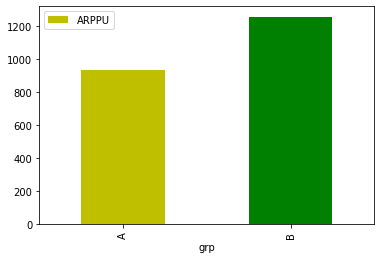

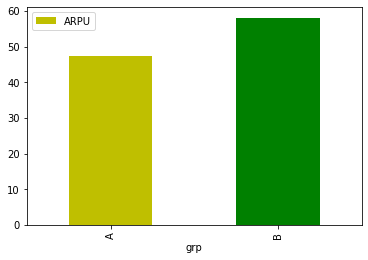

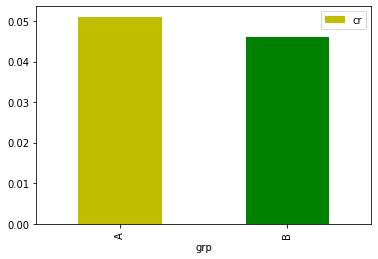

In [16]:
def plot_ARPU (df_plot):
       fig, figsize=(20, 5)
df_plot.plot (kind='bar', x='grp', y='ARPPU', color=['y', 'g'])
df_plot.plot (kind='bar', x='grp', y='ARPU', color=['y', 'g'])
df_plot.plot (kind='bar', x='grp', y='cr', color=['y', 'g'])
plt.show()